<a href="https://colab.research.google.com/github/KickDirtBaseball/register/blob/master/The_Legit_Leaderboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pybaseball --upgrade
from pybaseball import statcast
import pandas as pd
from joblib import load

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 51.2 MB/s eta 0:00:00


In [5]:
# 2025 April example — adjust as needed
df = statcast(start_dt="2025-04-01", end_dt="2025-04-30")

This is a large query, it may take a moment to complete


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = d

In [6]:
df = df[df['description'].isin(['called_strike', 'ball'])].copy()
df = df[df['player_name'].notna()]
df['count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str)
df['hand_matchup'] = df['p_throws'] + '_' + df['stand']

In [7]:
from google.colab import drive
drive.mount('/content/drive')

model_path = "/content/drive/MyDrive/framing_model_2025 2V.04.joblib"
preprocessor_path = "/content/drive/MyDrive/FramingPreprocessorV.4.joblib"

framing_model = load(model_path)
preprocessor = load(preprocessor_path)

Mounted at /content/drive


In [8]:
features = [
    'plate_x', 'plate_z', 'sz_top', 'sz_bot', 'zone',
    'release_extension', 'release_pos_x', 'release_pos_z', 'release_speed',
    'pitch_type', 'hand_matchup', 'count', 'stand', 'p_throws'
]

df = df.dropna(subset=features)
X = preprocessor.transform(df[features])
df['strike_prob'] = framing_model.predict_proba(X)[:, 1]
df['is_strike'] = (df['description'] == 'called_strike').astype(int)
df['framing_value'] = df['is_strike'] - df['strike_prob']

In [ ]:
df.head(3)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,count,hand_matchup,strike_prob,is_strike,framing_value
2793,ST,2025-04-30,86.8,-1.93,5.69,"Svanson, Matt",668715,694335,NaN,ball,...,<NA>,<NA>,<NA>,<NA>,<NA>,1-1,R_R,0.15,0,-0.15
2893,SI,2025-04-30,96.2,-1.64,5.7,"Svanson, Matt",668715,694335,NaN,called_strike,...,<NA>,<NA>,<NA>,<NA>,<NA>,1-0,R_R,0.98,1,0.02
3000,FC,2025-04-30,90.5,-1.58,5.8,"Svanson, Matt",668715,694335,NaN,ball,...,<NA>,<NA>,<NA>,<NA>,<NA>,0-0,R_R,0.02,0,-0.02


In [ ]:
# Example list of actual catcher names
catcher_names = ['Logan O’Hoppe', 'Austin Wells', 'Yainer Diaz', 'Bo Naylor', 'Shea Langeliers']  # etc.

leaderboard = (
    df[df['player_name'].isin(catcher_names)]
    .groupby('player_name')
    .agg(
        total_pitches=('framing_value', 'count'),
        total_framing_value=('framing_value', 'sum'),
    )
    .assign(
        framing_per_1000=lambda x: x['total_framing_value'] / x['total_pitches'] * 1000
    )
    .sort_values('framing_per_1000', ascending=False)
    .reset_index()
)

leaderboard.head(20)

,player_name,total_pitches,total_framing_value,framing_per_1000


In [11]:
# Example: map fielder_2 to name
id_to_name = {
    123456: 'Logan O’Hoppe',
    234567: 'Cal Raleigh',
    # add more here...
}
df['catcher_name'] = df['fielder_2'].map(id_to_name)

In [12]:
df['predicted_strike_prob'] = framing_model.predict_proba(X_transformed)[:, 1]

NameError: name 'X_transformed' is not defined

In [14]:
from pybaseball import statcast
import pandas as pd
from datetime import datetime

start_date = "2025-03-20"
end_date = datetime.today().strftime("%Y-%m-%d")

# Pull Statcast data
statcast_data = statcast(start_date, end_date)
statcast_data.to_csv("/content/2025_statcast.csv", index=False)

# Preview
statcast_data.head()

This is a large query, it may take a moment to complete


/usr/local/lib/python3.11/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/86 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_cop

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
3288,SI,2025-06-11,97.2,1.94,5.55,"Soto, Gregory",672761,642397,field_out,hit_into_play,...,<NA>,1.99,1.6,-1.6,<NA>,14.279219,-6.644513,30.825621,31.421513,31.374625
3429,SI,2025-06-11,95.4,1.92,5.69,"Soto, Gregory",672761,642397,NaN,called_strike,...,<NA>,2.06,1.62,-1.62,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3543,FF,2025-06-11,97.3,1.75,5.69,"Soto, Gregory",679529,642397,strikeout,swinging_strike,...,<NA>,1.29,0.89,-0.89,<NA>,-12.240506,39.260756,25.382044,44.709041,-5.278488
3655,SI,2025-06-11,97.0,2.04,5.56,"Soto, Gregory",679529,642397,NaN,called_strike,...,<NA>,1.8,1.54,-1.54,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3777,SL,2025-06-11,86.2,1.88,5.81,"Soto, Gregory",679529,642397,NaN,swinging_strike,...,<NA>,2.86,0.0,0.0,<NA>,28.616913,-35.478115,31.863134,43.49626,44.546781


In [15]:
df["description"].value_counts()

,count
description,
ball,38877
called_strike,18842


In [16]:
from pybaseball import statcast, playerid_reverse_lookup
from joblib import load
import pandas as pd
import numpy as np

# ==== 1. Load Model + Preprocessor ====
model_path = "/content/drive/MyDrive/framing_model_2025 2V.04.joblib"
preprocessor_path = "/content/drive/MyDrive/FramingPreprocessorV.4.joblib"
framing_model = load(model_path)
preprocessor = load(preprocessor_path)

# ==== 2. Pull Statcast Data ====
df = statcast(start_dt="2025-03-28", end_dt="2025-06-10")

# ==== 3. Prep Data ====
df = df[df["description"].isin(["called_strike", "ball"])]
df["is_strike"] = (df["description"] == "called_strike").astype(int)
df["count"] = df["balls"].astype(str) + "-" + df["strikes"].astype(str)
df["hand_matchup"] = df["p_throws"].astype(str) + "_" + df["stand"].astype(str)
df = df[df["fielder_2"].notna()].copy()
df["fielder_2"] = df["fielder_2"].astype(int)

# ==== 4. Map Catcher IDs to Names ====
ids = df["fielder_2"].unique()
name_map = playerid_reverse_lookup(ids, key_type="mlbam")
id_to_name = dict(zip(name_map.key_mlbam, name_map.name_first + " " + name_map.name_last))
df["catcher_name"] = df["fielder_2"].map(id_to_name)
df = df[df["catcher_name"].notna()]

# ==== 5. Predict + Calculate Framing Value ====
X = df.copy()
X_transformed = preprocessor.transform(X)
df["predicted_strike_prob"] = framing_model.predict_proba(X_transformed)[:, 1]
df["framing_value"] = df["is_strike"] - df["predicted_strike_prob"]

# ==== 6. Leaderboard ====
leaderboard = df.groupby("catcher_name").agg(
    total_pitches=("framing_value", "count"),
    total_framing_value=("framing_value", "sum")
).reset_index()
leaderboard["framing_per_1000"] = 1000 * leaderboard["total_framing_value"] / leaderboard["total_pitches"]
leaderboard = leaderboard.sort_values(by="framing_per_1000", ascending=False)

# Show leaderboard
leaderboard.head(25)

This is a large query, it may take a moment to complete


/usr/local/lib/python3.11/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_cop

Gathering player lookup table. This may take a moment.


,catcher_name,total_pitches,total_framing_value,framing_per_1000
5,aramis garcia,6,0.25,41.666667
60,mickey gasper,4,0.10,25.000000
40,j. c. escarra,1132,21.26,18.780919
56,luke maile,190,3.05,16.052632
52,kyle teel,176,2.78,15.795455
36,hayden senger,710,10.59,14.915493
2,alejandro kirk,3354,38.14,11.371497
7,austin hedges,1435,14.50,10.104530
34,gabriel moreno,3225,28.59,8.865116
17,carlos narváez,3489,30.63,8.779020


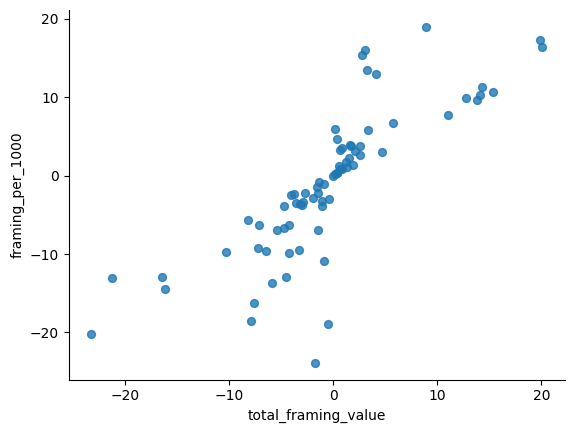

In [ ]:
# @title total_framing_value vs framing_per_1000

from matplotlib import pyplot as plt
leaderboard.plot(kind='scatter', x='total_framing_value', y='framing_per_1000', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)